In [46]:
import os
import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt
import antea.elec    .tof_functions as tf
import antea.database.load_db       as db
from antea.io.mc_io import load_mcsns_response
from antea.io.mc_io import load_mcTOFsns_response

In [2]:
def find_first_time_of_sensors(tof_response, sns_ids, num_init_sns):
    tof    = tof_response[tof_response.sensor_id.isin(sns_ids)]
    min_t  = tof.time_bin.min()
    min_df = tof[tof.time_bin == min_t]

    if len(min_df)>1:
        min_id = min_df[min_df.sensor_id == min_df.sensor_id.min()].sensor_id.values[0]
    else:
        min_id = min_df.sensor_id.values[0]

    return np.abs(min_id), min_t

In [3]:
evt          = 210000000
path1        = '/data5/users/carmenromo/PETALO/PETit/PETit-ring/ring_dataframes_analysis/'
path2        = 'study_number_pes_for_tof/data_full_ring_new/full_body_phantom_spe.7000.pet.h5'
file_name    = path1+path2
tof_response = load_mcTOFsns_response(file_name)
sns_response = load_mcsns_response(file_name)
evt_tof      = tof_response[tof_response.event_id == evt]
evt_sns      = sns_response[sns_response.event_id == evt]

evt_tof.head()

,event_id,sensor_id,time_bin,charge
0,210000000,-65425,638,1
1,210000000,-65425,644,1
2,210000000,-65425,675,1
3,210000000,-65425,778,1
4,210000000,-65425,852,1


In [4]:
evt_tof[evt_tof.sensor_id==-65425].groupby(['sensor_id'])[['time_bin']].min()

,time_bin
sensor_id,
-65425,638


In [5]:
mins = evt_tof.groupby(['sensor_id'])[['time_bin']].min().sort_values('time_bin')
num_init_sens = 10
mean_time_init_sens = mins[:num_init_sens].time_bin.mean()
print(mean_time_init_sens)
s_id_init_sens = mins[:num_init_sens].index.values

405.4


#### To take the average position it is needed to weight with the charge of each sensor:

In [6]:
evt_sns_init_sens = evt_sns[evt_sns.sensor_id.isin(-s_id_init_sens)]
charges_init_sens = evt_sns_init_sens.groupby(['sensor_id'])[['charge']].sum()
charges_init_sens

,charge
sensor_id,
33583,9
33953,8
64323,14
64326,4
64691,15
65059,16
65062,2
65426,18
65429,11


In [7]:
DataSiPM     = db.DataSiPMsim_only('petalo', 0)
DataSiPM_idx = DataSiPM.set_index('SensorID')

sipms         = DataSiPM_idx.loc[evt_sns_init_sens.sensor_id]
sns_positions = np.array([sipms.X.values, sipms.Y.values, sipms.Z.values]).transpose()
sns_positions

array([[-175.916,  369.899,  255.5  ],
       [-182.206,  366.842,  234.5  ],
       [-194.624,  360.407,  255.5  ],
       [-182.206,  366.842,  248.5  ],
       [-182.206,  366.842,  241.5  ],
       [-200.749,  357.032,  248.5  ],
       [-169.575,  372.849,  262.5  ],
       [-200.749,  357.032,  234.5  ],
       [ 117.226, -392.467, -346.5  ],
       [ 103.759, -396.24 , -353.5  ]])

In [8]:
np.average(sns_positions, axis=0, weights=charges_init_sens.values.T[0])

array([-129.27150926,  208.22714815,  123.99074074])

In [9]:
## weighted average tof time sensors:
np.average(mins[:num_init_sens].time_bin, axis=0, weights=charges_init_sens.values.T[0])

407.1203703703704

In [10]:
def find_selected_times_of_sensors(evt_sns, evt_tof, sns_ids, num_sel_sns, DataSiPM_idx):
    tof              = evt_tof[evt_tof.sensor_id.isin(sns_ids)]
    min_ts           = tof.groupby(['sensor_id'])[['time_bin']].min().sort_values('time_bin')
    mean_t_sel_sns   = min_ts[:num_sel_sns].time_bin.mean()
    ids_sel_sns      = min_ts[:num_sel_sns].index.values
    evt_sns_sel_sns  = evt_sns[evt_sns.sensor_id.isin(-ids_sel_sns)]
    charges_sel_sns  = evt_sns_sel_sns.groupby(['sensor_id'])[['charge']].sum().values.T[0]
    sipms            = DataSiPM_idx.loc[evt_sns_sel_sns.sensor_id]
    sns_positions    = np.array([sipms.X.values, sipms.Y.values, sipms.Z.values]).T
    weig_pos_sel_sns = np.average(              sns_positions, axis=0, weights=charges_sel_sns)
    weig_t_sel_sns   = np.average(min_ts[:num_sel_sns].time_bin, axis=0, weights=charges_sel_sns)
    return ids_sel_sns, charges_sel_sns, mean_t_sel_sns, weig_t_sel_sns, weig_pos_sel_sns

In [11]:
sns_ids = evt_tof.sensor_id.values
find_selected_times_of_sensors(evt_sns, evt_tof, sns_ids, 2, DataSiPM_idx)

(array([-64323, -65793]),
 array([14, 11], dtype=uint32),
 380.5,
 380.08,
 array([-176.64836,  369.48508,  246.82   ]))

In [81]:
from antea.io.mc_io import load_configuration
testfile = '/data5/users/carmenromo/PETALO/PETit/PETit-ring/ring_dataframes_analysis/ring_dataframes_files/petit_ring_tof_all_tables.000.pet.h5'

In [82]:
load_configuration(testfile)

,param_key,param_value
0,num_events,20000
1,saved_events,4784
2,bin_size,1.000000 mus
3,tof_bin_size,5.000000 ps
4,interacting_events,4784
5,/PhysicsList/RegisterPhysics,G4EmStandardPhysics_option4
6,/PhysicsList/RegisterPhysics,G4OpticalPhysics
7,/PhysicsList/RegisterPhysics,G4RadioactiveDecayPhysics
8,/PhysicsList/RegisterPhysics,G4DecayPhysics
9,/PhysicsList/RegisterPhysics,NexusPhysics


In [13]:
if not evt_tof.empty:
    print('yess')

yess


### Analyzing data files:

In [44]:
num_of_init_pes = [1, 2, 3, 5, 8, 10]

time_diff1 = [[] for j in range(len(num_of_init_pes))]
time_diff2 = [[] for j in range(len(num_of_init_pes))]
ave_t1     = [[] for j in range(len(num_of_init_pes))]
ave_t2     = [[] for j in range(len(num_of_init_pes))]
wei_t1     = [[] for j in range(len(num_of_init_pes))]
wei_t2     = [[] for j in range(len(num_of_init_pes))]
wpos1      = [[] for j in range(len(num_of_init_pes))]
wpos2      = [[] for j in range(len(num_of_init_pes))]
pos_cart1  = []
pos_cart2  = []
event_ids  = []

filepath = '/data5/users/carmenromo/PETALO/PETit/PETit-ring/ring_dataframes_analysis/data_ctr/ctr_number_pes_for_tof/'

for filename in os.listdir(filepath):
    if filename.endswith('.npz'):
        print(filename)
        my_file = filepath+filename
        d   = np.load(my_file)
        for i in d['pos_cart1']:
            pos_cart1.append(i)
        for i in d['pos_cart2']:
            pos_cart2.append(i)
        for i in d['event_ids']:
            event_ids.append(i)
        for j in range(6):
            for i in d['time_diff1'][j]:
                time_diff1[j].append(i)
            for i in d['time_diff2'][j]:
                time_diff2[j].append(i)
            for i in d['ave_t1'][j]:
                ave_t1[j].append(i)
            for i in d['ave_t2'][j]:
                ave_t2[j].append(i)
            for i in d['wei_t1'][j]:
                wei_t1[j].append(i)
            for i in d['wei_t2'][j]:
                wei_t2[j].append(i)
            for i in d['wpos1'][j]:
                wpos1[j].append(i)
            for i in d['wpos2'][j]:
                wpos2[j].append(i)
        
        
time_diff1 = np.array(time_diff1)
time_diff2 = np.array(time_diff2)
ave_t1     = np.array(ave_t1    )
ave_t2     = np.array(ave_t2    )
wei_t1     = np.array(wei_t1    )
wei_t2     = np.array(wei_t2    )
wpos1      = np.array(wpos1     )
wpos2      = np.array(wpos2     )
pos_cart1  = np.array(pos_cart1 )
pos_cart2  = np.array(pos_cart2 )
event_ids  = np.array(event_ids )
print(len(wpos2[0]))

full_body_ctr_number_pes_for_tof_44_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_35_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_10_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_28_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_11_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_8_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_33_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_15_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_4_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_42_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_1_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_48_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_26_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_29_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_45_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_23_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_41_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_0_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_31_1_4_5_4_2.npz
full_body_ctr_number_pes_for_tof_22_1_4_5_4_2.npz
full

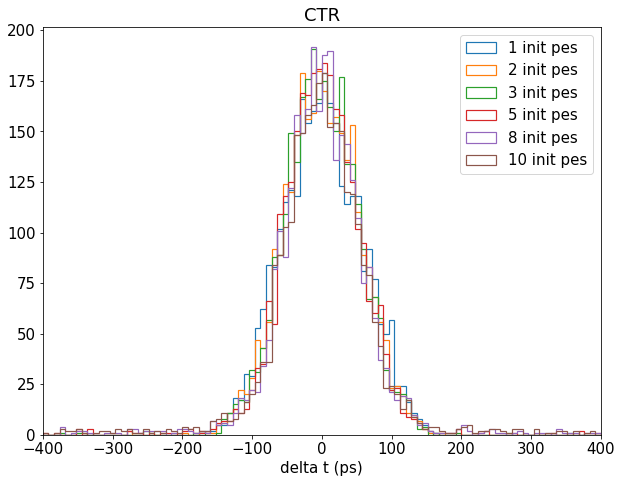

In [50]:
plt.rcParams["font.size"]      = 15
plt.rcParams["figure.figsize"] = 10, 7.5
plot_range = (-400, 400)
bins = np.histogram(np.hstack((time_diff1[0], time_diff1[1], time_diff1[2], time_diff1[3], time_diff1[4])), 
                    bins=100, range=plot_range)[1]
for j, num in enumerate(num_of_init_pes):
    plt.hist(time_diff1[j], bins=bins, histtype='step', linewidth=1.2, label=f'{num} init pes')
plt.title('CTR')
plt.xlabel('delta t (ps)')
plt.xlim(plot_range)
plt.legend()
plt.show()

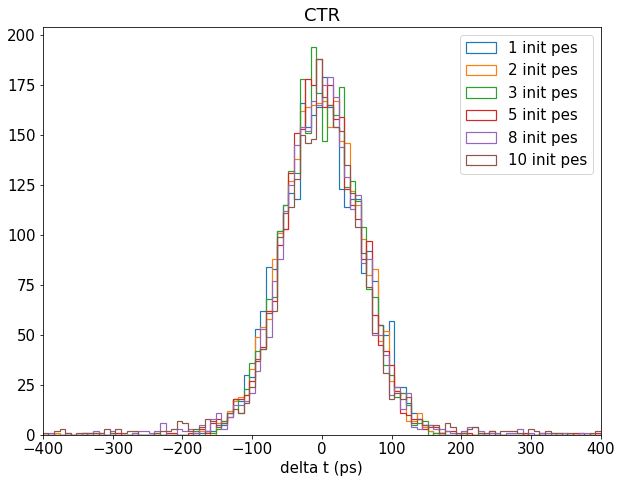

In [51]:
plt.rcParams["font.size"]      = 15
plt.rcParams["figure.figsize"] = 10, 7.5
plot_range = (-400, 400)
bins = np.histogram(np.hstack((time_diff2[0], time_diff2[1], time_diff2[2], time_diff2[3], time_diff2[4])), 
                    bins=100, range=plot_range)[1]
for j, num in enumerate(num_of_init_pes):
    plt.hist(time_diff2[j], bins=bins, histtype='step', linewidth=1.2, label=f'{num} init pes')
plt.title('CTR')
plt.xlabel('delta t (ps)')
plt.xlim(plot_range)
plt.legend()
plt.show()